In [1]:
%matplotlib widget
import yfinance as yf
from pathlib import Path
from datetime import date, timedelta, datetime, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm

pd.options.mode.copy_on_write = True


def fetch_ticker(ticker="^GSPC", start="1990-01-01", interval="15m"):
    end = date.today()
    if interval == "1h":
        start = end - timedelta(days=720)
    p = Path(f"data/cache/{interval}/{ticker}.csv")
    p.parent.mkdir(parents=True, exist_ok=True)
    if not p.is_file() or date.fromtimestamp(p.stat().st_mtime) < date.today():
        data = yf.download(
            ticker, start=start, end=end, interval=interval, prepost=True
        )
        data.columns = data.columns.droplevel(-1)
        data.to_csv(p)
    else:
        data = pd.read_csv(p, index_col=0, parse_dates=[0])
    return data


df = fetch_ticker("^GSPC", interval="1d", start="1985-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
def plot_entry_and_exit_points(stock_data: pd.DataFrame, ma: int = 325):
    # Create a subplot with 2 rows: the upper row for price data, lower row for volume
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3],
    )  # Adjust row heights as needed

    # --- Price Plot (Row 1) ---
    # Add closing price line
    fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=stock_data["Close"],
            mode="lines",
            name="Closing Price",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    # Add moving average line
    fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=stock_data[f"{ma}_MA"],
            mode="lines",
            name="Moving Average",
            line=dict(color="yellow"),
        ),
        row=1,
        col=1,
    )

    # Add long entry and exit markers
    long_entry_indices = stock_data.index[stock_data["Long_Entry"]]
    long_entry_prices = stock_data["Close"][stock_data["Long_Entry"]]
    long_exit_indices = stock_data.index[stock_data["Long_Exit"]]
    long_exit_prices = stock_data["Close"][stock_data["Long_Exit"]]

    fig.add_trace(
        go.Scatter(
            x=long_entry_indices,
            y=long_entry_prices,
            mode="markers",
            name="Long Entry Signal",
            marker=dict(color="green", size=10, symbol="circle"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=long_exit_indices,
            y=long_exit_prices,
            mode="markers",
            name="Long Exit Signal",
            marker=dict(color="red", size=10, symbol="circle"),
        ),
        row=1,
        col=1,
    )

    # Plot holding period segments separately to avoid unwanted connections
    segments = []
    current_segment = []
    for i in range(len(stock_data)):
        if stock_data["Position"].iloc[i] == 1:
            current_segment.append(
                (stock_data.index[i], stock_data["Close"].iloc[i])
            )
        else:
            if current_segment:
                segments.append(current_segment)
                current_segment = []
    if current_segment:
        segments.append(current_segment)

    for segment in segments:
        x_vals, y_vals = zip(*segment)
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode="lines",
                name="Holding Period",
                line=dict(color="purple", width=3),
                opacity=0.8,
            ),
            row=1,
            col=1,
        )

    # --- Volume Plot (Row 2) ---
    fig.add_trace(
        go.Bar(
            x=stock_data.index,
            y=stock_data["Volume"],
            name="Volume",
            marker=dict(color="green"),
        ),
        row=2,
        col=1,
    )

    if f"vol_{ma}_MA" in stock_data.columns:
        # Overlay vol_ma_MA as a line
        fig.add_trace(
            go.Scatter(
                x=stock_data.index,
                y=stock_data[f"vol_{ma}_MA"],
                mode="lines",
                name=f"vol_{ma}_MA",
                line=dict(color="orange"),
            ),
            row=2,
            col=1,
        )

    # Update layout for better viewing
    fig.update_layout(
        title="Stock Closing Price with Long Entry Signals and Volume",
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_dark",
        hovermode="x unified",
        height=700,
    )
    # Set y-axis title for the volume subplot
    fig.update_yaxes(title_text="Volume", row=2, col=1)

    fig.show()

In [3]:
moving_average = 325
df['daily_return'] = df['Close'].pct_change().fillna(0)
df[f'SMA_{moving_average}'] = df['Close'].rolling(window=325, min_periods=325).mean()
df['Long_Entry'] = (df['Close'].shift(1) > df[f'SMA_{moving_average}'].shift(1)).astype(int)
df['Long_Exit']  = (df['Close'].shift(1) < df[f'SMA_{moving_average}'].shift(1)).astype(int)
df['is_first'] = df.index.to_series().groupby([df.index.year, df.index.month]).transform('min') == df.index
df['overnight_pct_change'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
df.dropna(inplace=True)

In [29]:
class Depot:
    cash: float
    shares: float
    leverage_factor: int
    history: list[float]
    leveraged: bool = False
    cert_units: float
    invested_cash: int  # only tracks the cash amount invested
    buy_in: float
    tax_allowance: float # Größe des Verlusttopfs. Negativwerte = gezahlte Steuern
    depot_runtime: int # how long the depot exists in days, used for tax allowance
    strategy: bool # indicates if the depot is applying the sma strategy
    paid_taxes: float # tracks taxes for debugging

    def __init__(self, starting_cash: float, leverage_factor: int = 1, strategy:bool=False):
        self.cash = starting_cash
        self.invested_cash = starting_cash
        self.leverage_factor = leverage_factor
        self.history = []  # to record daily portfolio value
        self.invest_history = []  # to record daily portfolio value
        if leverage_factor == 1:
            self.leveraged = False
            self.shares = 0.0
        else:
            self.leveraged = (
                True  # uses certificate units and a certificate price
            )
            self.cert_units = 0.0
            self.cert_price = 1.0  # start at an arbitrary value
        self.tax_allowance = 1000
        self.buy_in = 0
        self.depot_runtime = 0
        self.strategy = strategy
        self.paid_taxes = 0

    def deposit(self, amount, price=None):
        if amount > self.cash:
            raise ValueError(
                "Not enough cash! Cash: %s - Investment: %s", self.cash, amount
            )
        if not self.leveraged:
            if price is None:
                raise ValueError("Price is required for unleveraged deposit.")
            # Buy shares at the current price.
            self.shares += amount / price
        else:
            # In leveraged mode, deposit buys certificate units at the current certificate price.
            self.cert_units += amount / (
                self.cert_price + 0.01 * self.cert_price
            )  # add 1% spread
        self.cash -= amount
        # as we always look at the full portfolio value for profit calculations
        # we can just deduct the certificate fees from cash
        if self.leveraged:
            self.cash -= amount * 0.00003*20.83  # 0.75%/annual = 0.00003/Tag, 20.83 Handelstage pro Monat, da monatliche Deposits
            self.cash -= amount * 0.0000196*20.83  # transactioncosts: 0.49%/annual
        else:
            self.cash -= amount * 0.000004*20.83  # 0.1%/annual
        self.buy_in += amount
        # print("buy in: ", self.buy_in)

    def add_cash(self, amount: float):
        self.cash += amount
        self.invested_cash += amount

    def calculate_tax(self, sold_position: float):
        profit = sold_position - self.buy_in
        print(profit)
        if profit > 0:
            # Calculate tax due as 25% of the profit.
            tax = profit * 0.25
            # If there's a positive tax_allowance, offset the tax by that amount.
            if self.tax_allowance > 0:
                offset = min(self.tax_allowance, tax)
                self.tax_allowance -=offset
                tax -= offset
            # if tax wasn't fully offset, 
            if tax > 0:
                self.tax_allowance -= tax
        else:
            tax = 0
            loss = abs(profit)
            # For losses, tax is 0.
            # If tax_allowance is negative, that indicates you previously paid taxes.
            # Refund those taxes (the absolute value of tax_allowance) into cash.
            if self.tax_allowance < 0:
                refund = min(abs(self.tax_allowance), loss)
                self.cash += refund
            self.tax_allowance += loss
        print(tax)
        self.buy_in = 0  # assuming we always sell 100%
        # print(f"allowance: {self.tax_allowance}\ntax: {tax}\nprofit:{profit}")
        return tax

    def sell_all(self, price=None, overnight_chg: float=None):
        # print("Cash before: ", self.cash)
        if not self.leveraged:
            if price is None:
                raise ValueError("Price is required for unleveraged sell_all.")
            # Sell all shares at the current price.
            sold_position = self.shares * price
            self.cash += sold_position
            self.shares = 0.0
        else:
            cert_price = self.cert_price
            if overnight_chg:
                # calculate cert value on open
                cert_price *= 1+self.leverage_factor*overnight_chg
            # Sell all certificate units.
            sold_position = self.cert_units * (
                cert_price - cert_price * 0.01
            )  # add 1% spread
            self.cash += sold_position
            self.cert_units = 0.0
        # print("OVERNIGHT: ", cert_price)
        tax = self.calculate_tax(sold_position)
        self.cash -= tax
        self.paid_taxes += tax
        # print("Cash after: ", self.cash)

    def update(self, daily_return):
        # In unleveraged mode nothing changes (share count is fixed; value comes from current price).
        # In leveraged mode, update the certificate price by applying the leveraged daily return.
        if self.leveraged:
            self.cert_price *= 1 + self.leverage_factor * daily_return
        # dca does not sell until the end, so we only need to care about tax allowance for the lev strategies
        if self.strategy and self.depot_runtime % 250==0 and self.depot_runtime > 0:
            self.tax_allowance = 1000 
            # print(self.cert_price)

    def get_portfolio_value(self, price=None):
        if not self.leveraged:
            if price is None:
                raise ValueError(
                    "Price is required to compute portfolio value in unleveraged mode."
                )
            return self.cash + self.shares * price
        else:
            return self.cash + self.cert_units * self.cert_price

    def record_value(self, price=None):
        # Record the current portfolio value into the history.
        val = self.get_portfolio_value(price)
        self.history.append(val)
        self.invest_history.append(self.invested_cash)

    def is_invested(self):
        if not self.leveraged:
            return self.shares > 0
        else:
            return self.cert_units > 0

In [30]:
def simulate_investments(
    df: pd.DataFrame,
    investment: int = 1000,
    start_invest: int = 10000,
    leverage: int = 1,
    strategy: bool = False,
) -> tuple[list[int], list[int]]:
    start_price = df["Close"][0]
    depot = Depot(start_invest, leverage_factor=leverage, strategy=strategy)
    depot.deposit(depot.cash, start_price)

    # --- 3. Simulate Daily Portfolio Values ---
    for _, row in df.iterrows():
        if row["is_first"] and (
            (strategy and row["Long_Entry"]) or not strategy
        ):
            depot.add_cash(investment)
            depot.deposit(depot.cash, row["Close"])

        if strategy and row["Long_Exit"]:
            depot.sell_all(row["Close"], row["overnight_pct_change"])

        if strategy and row["Long_Entry"] and not depot.is_invested():
            depot.deposit(depot.cash, row["Close"])

        # update cert value every day
        depot.update(row["daily_return"])
        depot.record_value(row["Close"])
    depot.sell_all(row["Close"])
    depot.record_value(row["Close"])
    return depot.history, depot.invest_history, depot.paid_taxes

In [18]:
plan_configs = {
    "dca": {"leverage": 1, "strategy": False},
    "dca_lev_x2": {"leverage": 2, "strategy": False},
    "dca_lev_x3": {"leverage": 3, "strategy": False},
    "sma": {"leverage": 1, "strategy": True},
    "sma_lev_x2": {"leverage": 2, "strategy": True},
    "sma_lev_x3": {"leverage": 3, "strategy": True},
}

In [19]:
def calc_max_drawdown(portfolio_values, cash_values):
    """
    Given a sequence of portfolio values and cash states, compute the maximum drawdown.
    Returns the minimum drawdown (a negative percentage).
    """
    values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(cash_values)
    drawdowns = (values - running_max) / running_max
    return drawdowns.min()

def calc_final_profit(portfolio_values, invested_cash):
    """
    Computes the final profit as a percentage gain/loss.
    """
    values = np.array(portfolio_values)
    return values[-1] / invested_cash - 1

In [20]:
#TODO ensure all simulations for each strategy run on shared timeframes
def monte_carlo_simulation_for_plans(
    df: pd.DataFrame,
    horizon_years: int,
    num_simulations: int,
    plan_configs: dict,
    start_invest: int=10000,
    investment:int = 1000
) -> dict[pd.DataFrame]:
    """
    Run Monte Carlo simulations for a given plan.
    
    Parameters:
      df: DataFrame with your trading data. It must have a DateTimeIndex and required columns.
      horizon_years: The length of each simulation (in years).
      num_simulations: How many simulations to run.
      investment: Monthly contribution.
      start_invest: Initial cash (starting investment).
      leverage: Leverage factor.
      strategy: If True, use SMA-based strategy; otherwise use DCA.
      
    Returns:
      A DataFrame with the final profit and maximum drawdown for each simulation.
    """
    results:dict[list] = {}
    # Create a DateOffset for the horizon.
    horizon_offset = pd.DateOffset(years=horizon_years)
    data = df.copy() # ensure original is not edited
    # Get possible start dates (all dates for which start_date + horizon is before last date).
    possible_starts = data.index[data.index <= (data.index[-1] - horizon_offset)]
    possible_starts = possible_starts.to_numpy()
    
    if len(possible_starts) == 0:
        raise ValueError("Not enough data for the given horizon.")
    for plan_name in plan_configs.keys():
        results[plan_name] = list()
    
    for i in range(num_simulations):
        start_date = np.random.choice(possible_starts)
        end_date = start_date + horizon_offset
        data_sub = data.loc[start_date:end_date]
        # Skip simulation if the slice is too short.
        if len(data_sub) < 10:
            continue
        for plan_name, config in plan_configs.items():
            portfolio_history, cash_history, paid_taxes = simulate_investments(
                data_sub,
                investment=investment,
                start_invest=start_invest,
                leverage=config["leverage"],
                strategy=config["strategy"],
            )
            final_profit = calc_final_profit(portfolio_history, cash_history[-1])
            max_dd = calc_max_drawdown(portfolio_history, cash_history)
            results[plan_name].append({
                "final_profit": final_profit,
                "max_drawdown": max_dd,
                "start_date": start_date,
                "end_date": data_sub.index[-1],
                "paid_taxes":paid_taxes
            })
    for plan_name in plan_configs.keys():
        results[plan_name] = pd.DataFrame(results[plan_name])
    return results


In [21]:
horizons = [1, 2, 3, 5, 10]
num_simulations = 1000
investment = 1000
start_invest = 10000
monte_carlo_results = {}

for horizon in tqdm(horizons):
    monte_carlo_results[horizon] = monte_carlo_simulation_for_plans(
        df,
        horizon,
        num_simulations,
        plan_configs=plan_configs,
        start_invest=start_invest,
        investment=investment,
    )

    # Print summary statistics

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_2032/4132728856.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start_price = df["Close"][0]


In [31]:
# monte_carlo_results
a,b,c = simulate_investments(df[(df.index>='2016-12-05') & (df.index<='2017-12-05')], leverage=2)
a[-1], b[-1], c


5874.799184324911
468.69979608122776


/tmp/ipykernel_2032/4132728856.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start_price = df["Close"][0]


(27383.392086366934, 22000, 468.69979608122776)

(np.float64(23233.480878143346), 22000, np.float64(0.0))

In [25]:
monte_carlo_results

{1: {'dca':      final_profit  max_drawdown start_date   end_date  paid_taxes
  0        0.056067     -0.052598 2004-12-14 2005-12-14         0.0
  1       -0.141219     -0.222022 2000-08-14 2001-08-14         0.0
  2        0.131783     -0.000083 2016-12-05 2017-12-05         0.0
  3       -0.033831     -0.234160 2002-05-07 2003-05-07         0.0
  4       -0.085087     -0.245609 2000-12-18 2001-12-18         0.0
  ..            ...           ...        ...        ...         ...
  995     -0.143815     -0.286866 2001-12-10 2002-12-10         0.0
  996      0.045042     -0.059437 2004-01-08 2005-01-07         0.0
  997      0.093177     -0.157495 2018-12-03 2019-12-03         0.0
  998     -0.087925     -0.087941 2015-01-20 2016-01-20         0.0
  999      0.096214     -0.076803 2009-12-07 2010-12-07         0.0
  
  [1000 rows x 5 columns],
  'dca_lev_x2':      final_profit  max_drawdown start_date   end_date  paid_taxes
  0        0.090234     -0.110296 2004-12-14 2005-12-14    0.0

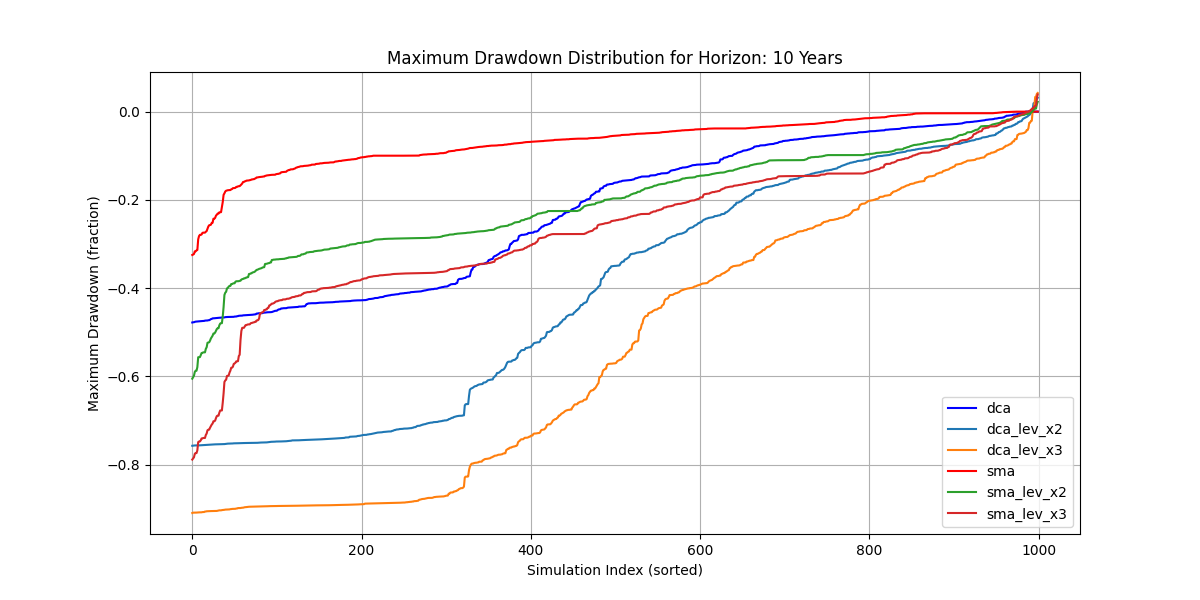

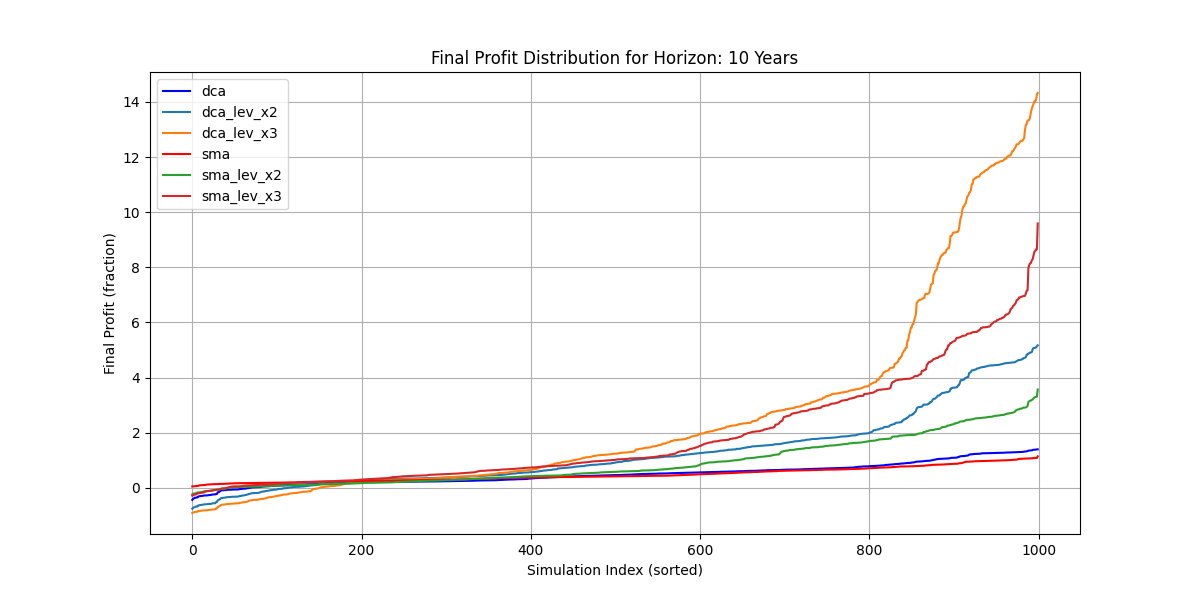

In [32]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

# For example, choose a single horizon (e.g., 10 years)
horizon = 10
results_for_horizon = monte_carlo_results[horizon]

# Define a color mapping for the strategies.
colors = {
    "cash": "black",
    "dca": "blue",
    "dca_lev": "green",
    "dca_lev2": "orange",
    "sma": "red",
    "sma_lev": "purple",
    "sma_lev2": "brown"
}

# --- Graph 1: Final Profit ---
fig1, ax1 = plt.subplots(figsize=(12, 6))
for plan_name, sim_df in results_for_horizon.items():
    # Sort the final profit values for a smooth line
    sorted_profit = np.sort(sim_df["final_profit"].values)
    x = np.arange(len(sorted_profit))
    ax1.plot(x, sorted_profit, label=plan_name, color=colors.get(plan_name, None))
    
    # # Calculate mean and median
    # mean_profit = np.mean(sorted_profit)
    # median_profit = np.median(sorted_profit)
    
    # # Overlay horizontal lines for mean (dashed) and median (dotted)
    # ax1.axhline(mean_profit, color=colors.get(plan_name, None), linestyle="--")
    # ax1.axhline(median_profit, color=colors.get(plan_name, None), linestyle=":")
    
ax1.set_xlabel("Simulation Index (sorted)")
ax1.set_ylabel("Final Profit (fraction)")
ax1.set_title(f"Final Profit Distribution for Horizon: {horizon} Years")
ax1.legend()
ax1.grid(True)

# --- Graph 2: Maximum Drawdown ---
fig2, ax2 = plt.subplots(figsize=(12, 6))
for plan_name, sim_df in results_for_horizon.items():
    # Sort the max_drawdown values for a smooth line
    sorted_dd = np.sort(sim_df["max_drawdown"].values)
    x = np.arange(len(sorted_dd))
    ax2.plot(x, sorted_dd, label=plan_name, color=colors.get(plan_name, None))
    
    # # Calculate mean and median
    # mean_dd = np.mean(sorted_dd)
    # median_dd = np.median(sorted_dd)
    
    # # Overlay horizontal lines for mean (dashed) and median (dotted)
    # ax2.axhline(mean_dd, color=colors.get(plan_name, None), linestyle="--")
    # ax2.axhline(median_dd, color=colors.get(plan_name, None), linestyle=":")
    
ax2.set_xlabel("Simulation Index (sorted)")
ax2.set_ylabel("Maximum Drawdown (fraction)")
ax2.set_title(f"Maximum Drawdown Distribution for Horizon: {horizon} Years")
ax2.legend()
ax2.grid(True)

plt.show()


In [34]:
results = {}
for plan in plan_configs.keys():
    results[plan] = dict()
    for key, value in monte_carlo_results.items():
        results[plan][key] = dict()
        for column in value[plan].columns:
            if column in ["start_date","end_date"]:
                continue
            results[plan][key][column] = value[plan][column].median()
            print(f"{plan} - profit: {value[plan][column].median()}")

dca - profit: 0.0855751109894074
dca - profit: -0.0513037752474572
dca - profit: 0.0
dca - profit: 0.12723862972234046
dca - profit: -0.07080621768976741
dca - profit: 113.12675247520383
dca - profit: 0.16526084886113168
dca - profit: -0.08934371467459978
dca - profit: 1208.0729667826217
dca - profit: 0.2576731313721424
dca - profit: -0.11798359890838021
dca - profit: 4683.343100761553
dca - profit: 0.463389197124657
dca - profit: -0.16120628036397133
dca - profit: 18776.079669325263
dca_lev_x2 - profit: 0.14513397106332548
dca_lev_x2 - profit: -0.11417678188262462
dca_lev_x2 - profit: 0.0
dca_lev_x2 - profit: 0.1960323998301693
dca_lev_x2 - profit: -0.16107413569858664
dca_lev_x2 - profit: 900.0647053631837
dca_lev_x2 - profit: 0.2731027635395811
dca_lev_x2 - profit: -0.19156992979863344
dca_lev_x2 - profit: 2867.5537945201904
dca_lev_x2 - profit: 0.4886128957228727
dca_lev_x2 - profit: -0.26320447501786604
dca_lev_x2 - profit: 10091.716960808662
dca_lev_x2 - profit: 0.916324460478975

In [210]:
results

{'dca': {1: {'final_profit': np.float64(0.0855791206172084),
   'max_drawdown': np.float64(-0.047853323506476905)},
  2: {'final_profit': np.float64(0.12945502918389373),
   'max_drawdown': np.float64(-0.07632644413225792)},
  3: {'final_profit': np.float64(0.16914991900268372),
   'max_drawdown': np.float64(-0.07655298773124289)},
  5: {'final_profit': np.float64(0.2543565170956221),
   'max_drawdown': np.float64(-0.11606084957125298)},
  10: {'final_profit': np.float64(0.44709205032047494),
   'max_drawdown': np.float64(-0.1521164729686567)}},
 'dca_lev_x2': {1: {'final_profit': np.float64(0.13914255299771683),
   'max_drawdown': np.float64(-0.10659185042972719)},
  2: {'final_profit': np.float64(0.20045529471458423),
   'max_drawdown': np.float64(-0.17011393854742174)},
  3: {'final_profit': np.float64(0.2915839486478783),
   'max_drawdown': np.float64(-0.1731416184465382)},
  5: {'final_profit': np.float64(0.4802253063038715),
   'max_drawdown': np.float64(-0.24384382080870473)},
 

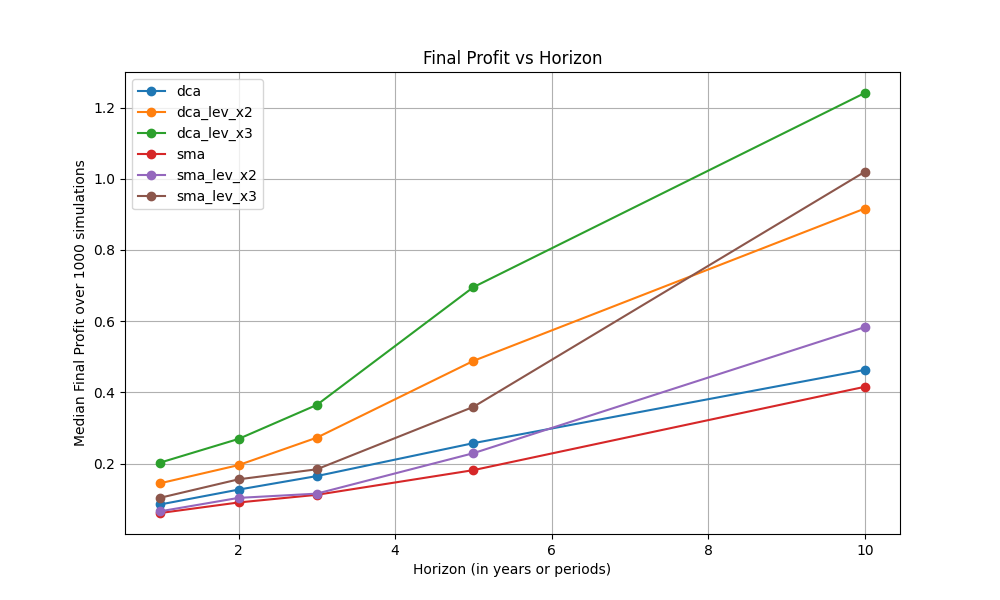

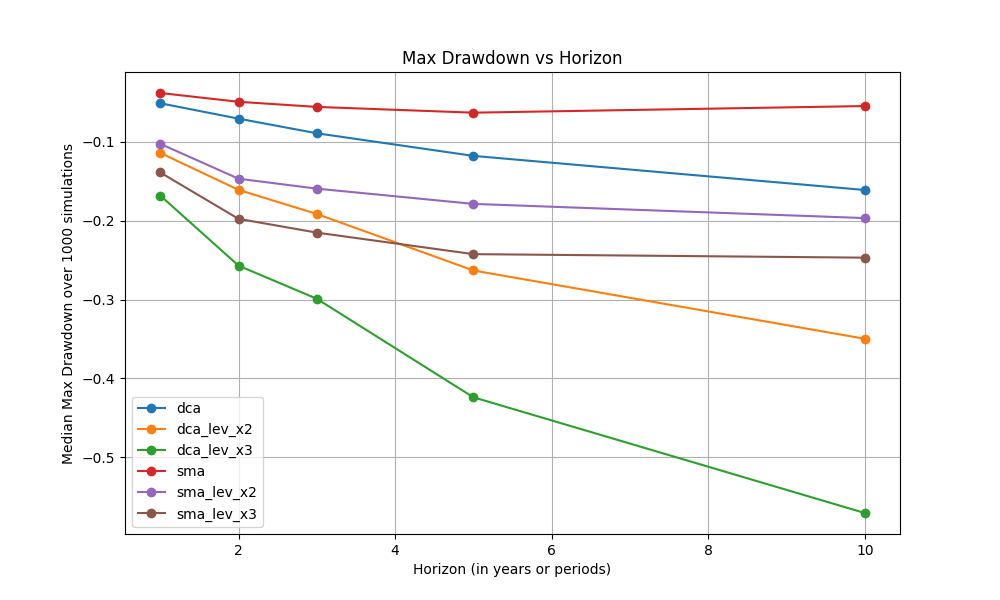

In [35]:
plt.figure(figsize=(10, 6))
for plan, horizons in results.items():
    # Sort horizons for proper plotting
    x = sorted(horizons.keys())
    y = [horizons[h]['final_profit'] for h in x]
    plt.plot(x, y, marker='o', label=plan)
    
plt.xlabel("Horizon (in years or periods)")
plt.ylabel("Median Final Profit over 1000 simulations")
plt.title("Final Profit vs Horizon")
plt.legend()
plt.grid(True)
plt.show()

# -------------------
# Plot for Max Drawdown
# -------------------
plt.figure(figsize=(10, 6))
for plan, horizons in results.items():
    x = sorted(horizons.keys())
    y = [horizons[h]['max_drawdown'] for h in x]
    plt.plot(x, y, marker='o', label=plan)
    
plt.xlabel("Horizon (in years or periods)")
plt.ylabel("Median Max Drawdown over 1000 simulations")
plt.title("Max Drawdown vs Horizon")
plt.legend()
plt.grid(True)
plt.show()

In [201]:
monte_carlo_results[10]

{'dca':    final_profit  max_drawdown start_date   end_date
 0      0.252798     -0.309725 1997-07-10 2007-07-10
 1     -0.076957     -0.428014 2000-07-19 2010-07-19
 2      0.105407     -0.409237 2001-03-20 2011-03-18,
 'dca_lev_x2':    final_profit  max_drawdown start_date   end_date
 0      0.415172     -0.581154 1997-07-10 2007-07-10
 1     -0.344468     -0.741709 2000-07-19 2010-07-19
 2     -0.016936     -0.725747 2001-03-20 2011-03-18,
 'dca_lev_x3':    final_profit  max_drawdown start_date   end_date
 0      0.505417     -0.772326 1997-07-10 2007-07-10
 1     -0.590543     -0.901154 2000-07-19 2010-07-19
 2     -0.252730     -0.893211 2001-03-20 2011-03-18,
 'sma':    final_profit  max_drawdown start_date   end_date
 0      0.377839     -0.047255 1997-07-10 2007-07-10
 1      0.112522     -0.065476 2000-07-19 2010-07-19
 2      0.260777     -0.003922 2001-03-20 2011-03-18,
 'sma_lev_x2':    final_profit  max_drawdown start_date   end_date
 0      0.561992     -0.167071 1997-07-